In [54]:
import numpy as np
import pandas as pd


import datetime as dt
from pylab import mpl, plt
from itertools import product

In [55]:
raw = pd.read_csv('datos\\tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [56]:
symbol = 'EUR='
data = pd.DataFrame(raw[symbol])
data.head()

,EUR=
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412


In [57]:
data['returns'] = np.log(data / data.shift(1))  # log returns

In [58]:
data.dropna(inplace=True)

In [59]:
data['direction'] = np.sign(data['returns']).astype(
    int)  # 1 si el precio subió, -1 si bajó
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


<Axes: >

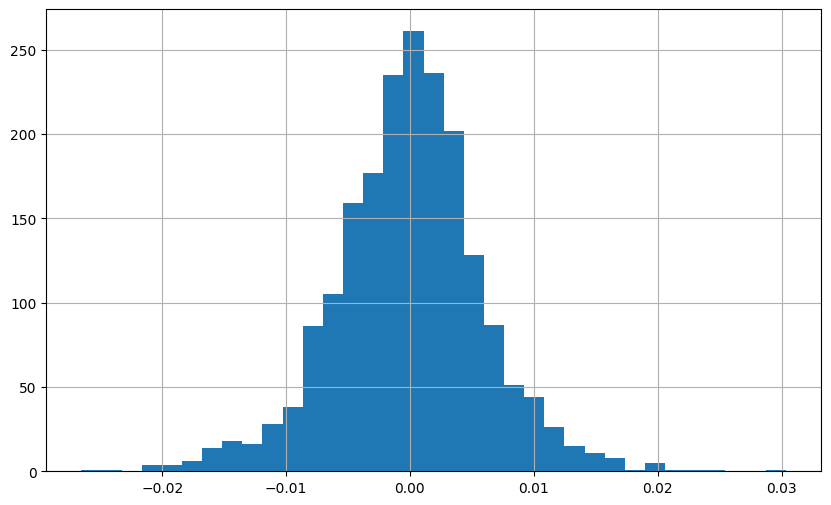

In [60]:
data['returns'].hist(bins=35, figsize=(10, 6))

In [61]:
lags = 2


def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = f'lag_{lag}'
        data[col] = data['returns'].shift(lag)
        cols.append(col)


create_lags(data)
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [62]:
data.dropna(inplace=True)

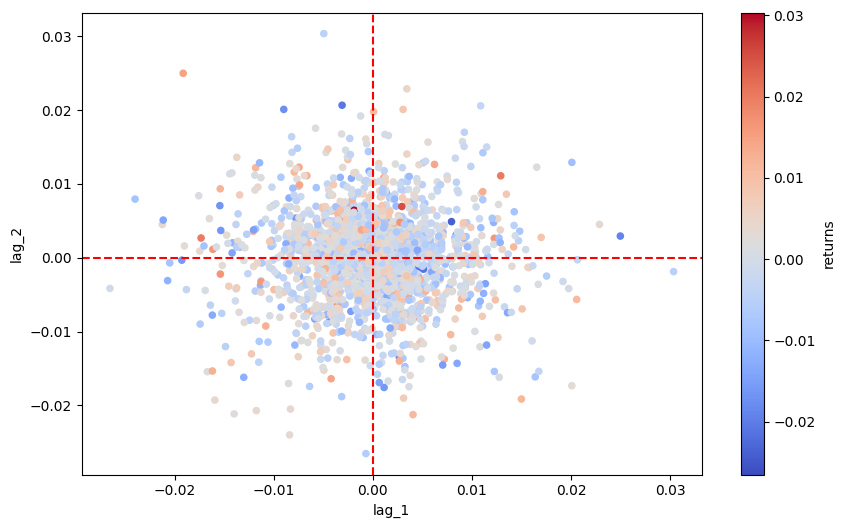

In [63]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns',
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--')

In [64]:
from sklearn.linear_model import LinearRegression

In [65]:
model = LinearRegression()

In [66]:
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])

In [67]:
data['pos_ols_2'] = model.fit(
    data[cols], data['direction']).predict(data[cols])

In [70]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2
Date,,,,,,,
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,-1
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,1,1


In [69]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(
    # convierte en -1 valores negativos y 1 positivos
    data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [71]:
data['pos_ols_1'].value_counts()

pos_ols_1
-1    1605
 1     364
Name: count, dtype: int64

In [72]:
data['pos_ols_2'].value_counts()

pos_ols_2
 1    1231
-1     738
Name: count, dtype: int64

In [73]:
(data['pos_ols_1'].diff() != 0).sum()

np.int64(701)

In [74]:

(data['pos_ols_2'].diff() != 0).sum()

np.int64(789)

In [75]:
data['strategy_ols_1'] = data['pos_ols_1'] * data['returns']
data['strategy_ols_2'] = data['pos_ols_2'] * data['returns']
data[['returns', 'strategy_ols_1', 'strategy_ols_2']].sum().apply(np.exp)

returns           0.807938
strategy_ols_1    1.345052
strategy_ols_2    1.418594
dtype: float64

<Axes: xlabel='Date'>

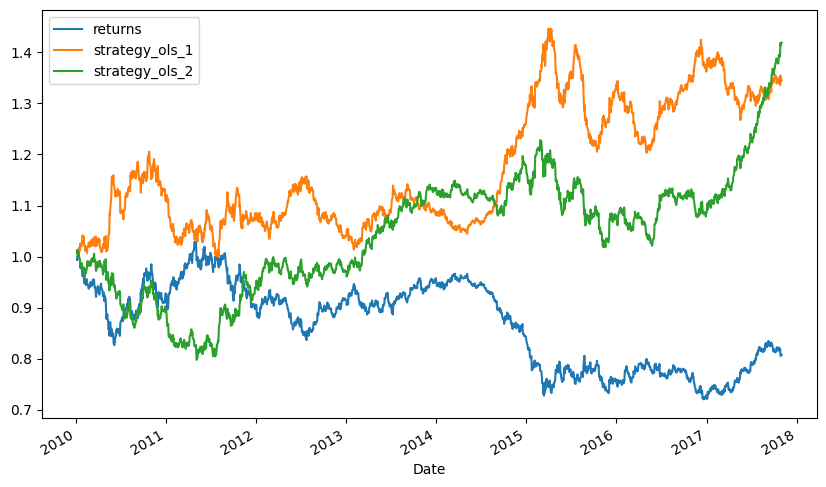

In [76]:
data[['returns', 'strategy_ols_1', 'strategy_ols_2']
     ].cumsum().apply(np.exp).plot(figsize=(10, 6))